In [227]:
import pandas as pd 
import numpy as np
import tensorly as tl
import plotly.express as px
import matplotlib.pyplot as plt 
from tensorly.decomposition import CP,tucker, parafac
from datetime import timedelta, date

In [228]:
df_FR = pd.read_excel('FINANCIAL_RATIOS_NEW.xlsx', index_col =[0], skiprows=[1])






In [229]:
df_FR

,AMAT US Equity,COKE US Equity,WDFC US Equity,AAPL US Equity,KLAC US Equity,SEIC US Equity,CSPI US Equity,ALOT US Equity,AMGN US Equity,CAMP US Equity,...,WMT US Equity.4,C US Equity.4,BA US Equity.4,Unnamed: 1109,Unnamed: 1110,Unnamed: 1111,Unnamed: 1112,Unnamed: 1113,BA US Equity.5,HPQ US Equity
2006-11-10,15.9515,33.4365,18.7771,36.4561,22.4769,30.0052,55.2000,24.3781,20.1813,12.4386,...,193734.9049,248778.9598,67703.1057,NaN,NaN,NaN,NaN,NaN,67703.1057,109530.9307
2006-11-17,16.4041,35.7514,18.5600,37.6535,23.9306,31.1099,56.5333,24.1045,19.9203,12.2456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70786.9893,108928.3600
2006-11-24,16.7663,35.5359,18.5886,40.1886,23.9444,30.7906,56.2000,24.6269,19.9176,12.3509,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70984.6741,108353.1788
2006-12-01,16.0511,34.1326,19.7301,40.0526,23.4491,30.4031,58.6667,24.8756,19.0604,16.7442,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70810.7115,108024.5038
2006-12-08,16.7210,36.7459,20.2393,38.7105,23.6389,31.2408,57.2000,24.9502,19.1978,17.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71269.3403,108572.2954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,14.6285,18.2930,37.8204,25.6062,16.1131,14.5609,36.7068,28.3810,13.8977,499.7665,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88059.0774,38584.7893
2022-05-06,14.9135,20.0395,37.4195,25.5461,16.7233,14.5008,36.7068,27.1800,14.0949,499.7665,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88094.5755,39069.3375
2022-05-13,14.8286,21.9931,38.1739,23.8943,16.9791,14.3309,36.7068,26.7375,14.5062,499.7665,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75256.0780,38742.7941
2022-05-20,14.1128,21.0654,36.2354,22.3480,16.9317,14.3910,36.7068,26.3372,14.7505,499.7665,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71410.4450,36499.1250


### Currently the features are PE, PS, PB, MCAP and PX_LAST need to further improve it with feature selection.

In [230]:
# df_FR = pd.read_excel('FINANCIAL_RATIOS_f.xlsx', index_col =[0])
price = None
FR_dic = {}
FR_list = ['PE', 'PX_LAST', 'PS','PB']
n = 0 
NUMBER_OF_STOCKS = 220
for i,name in enumerate(FR_list) : 
    FR_dic[name] = (df_FR.iloc[:,n:n+NUMBER_OF_STOCKS]
                    .set_index(df_FR.index)
                    )

    if name not in ['PX_LAST', 'MCAP'] : 
        FR_dic[name] = (FR_dic[name] - FR_dic[name].mean()) / FR_dic[name].std()
        
    if name in ['PX_LAST'] :

        price = FR_dic['PX_LAST']
        FR_dic[name] = np.log(FR_dic[name])
        FR_dic[name] = FR_dic[name].diff()
    
    # if name in ['MCAP'] : 
    #     FR_dic[name] = FR_dic[name] - FR_dic[name].shift(+1)
    
    FR_dic[name] = FR_dic[name][1:]
    n += NUMBER_OF_STOCKS + 2

COLUMN_NAMES = FR_dic['PE'].columns



### We attempt to predict $AAPL 's cumulative log returns 8 weeks from now based on historical data which has a lookback period of 13 weeks.


In [231]:
for col in FR_dic['PX_LAST'] : 
    if col.startswith('AAPL') : 
        y_predict = FR_dic['PX_LAST'][col]

AAPL_returns = pd.DataFrame(y_predict).set_axis(['Log Returns'], axis = 1)
AAPL_returns['Cumulative Log Returns'] = AAPL_returns['Log Returns'].cumsum()

def get_x_week_returns(log_returns, look_back_duration = 13) : 
    lookforward = 4
    sdate = AAPL_returns.index.values[0]
    edate = AAPL_returns.index.values[-1]
    s = (log_returns
     .reset_index()
     .iloc[look_back_duration:]
    )
    x_week_returns = s.rolling(lookforward).sum()
    x_week_returns.index = list(pd.date_range(sdate ,edate + pd.to_timedelta(2, unit='D') ,freq='w') - pd.to_timedelta(2, unit='D'))[:-look_back_duration]
    return x_week_returns.dropna() 


def to_simple_return(cum_log_ret) : 
    return np.exp(cum_log_ret) - 1

x_ret = get_x_week_returns(AAPL_returns['Log Returns'])
y_train = x_ret





# AAPL_simple_returns = to_simple_return(AAPL_returns['Cumulative Log Returns'][-1] )

(array([  3.,   1.,   6.,   7.,  49., 176., 308., 197.,  46.,   2.]), array([-0.50085395, -0.42000946, -0.33916498, -0.25832049, -0.17747601,
       -0.09663152, -0.01578703,  0.06505745,  0.14590194,  0.22674642,
        0.30759091]), <BarContainer object of 10 artists>)
(array([527.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 268.]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]), <BarContainer object of 10 artists>)


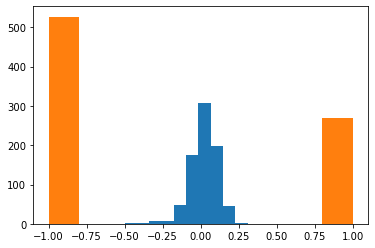

In [242]:
# plt.hist(y_arr, bins = 50)

# y_arr = y_arr['Log Returns']
y_arr = y_train.values
print(plt.hist(y_arr))

y_arr = y_arr.flatten()
y_arr[(y_arr > 0.060)] = 1

y_arr[y_arr <= 0.060] = -1

print(plt.hist(y_arr))


Split into < -5
-5,0
0,5
> 5



In [233]:
df_TI = pd.read_excel('TECH_NEW.xlsx', skiprows=[0])
# df_TI.columns = df_TI.columns.astype(str)


In [250]:
TI_dic = {}
TI_list = ['WLPR', 'RSI', 'ROC', 'MOM','HURST','BB_PERCENT']
n = 1

for _, TI in enumerate(TI_list) : 
    filter_col = [col for col in df_TI if col.startswith(TI)]
    TI_dic[TI] = (df_TI[filter_col]
                 .set_axis(COLUMN_NAMES, axis=1)
                 .set_index(df_TI['Dates'])
                 .iloc[:-1]
                 .fillna(method = 'ffill')
                 )
    TI_dic[TI] = (TI_dic[TI] - TI_dic[TI].mean()) / TI_dic[TI].std()

In [235]:
# # df_FR = pd.read_excel('FINANCIAL_RATIOS.xlsx', index_col =[0], skiprows=[1,2])
# df_PX = pd.read_excel('PRICE_DATA.xlsx', index_col =[0], skiprows=[1,2])


# df_PX.drop(list(df_PX.filter(regex='TTWO')), axis=1, inplace = True)
# df_PX.drop(list(df_PX.filter(regex='TSCO')), axis=1, inplace = True)
# df_PX.drop(list(df_PX.filter(regex='AXTI')), axis=1, inplace = True)
# df_PX.drop(list(df_PX.filter(regex='DISH')), axis=1, inplace = True)
# df_PX.drop(list(df_PX.filter(regex='TTEC')), axis=1, inplace = True)
# df_PX.drop(list(df_PX.filter(regex='ELTK')), axis=1, inplace = True)
# df_PX.drop(list(df_PX.filter(regex='LOGI')), axis=1, inplace = True)

# df_PX.to_excel('PRICE_DATA_f.xlsx')

In [236]:


    
    # FR_dic[name] = (FR_dic[name] - FR_dic[name].mean()) / FR_dic[name].std()

# COLUMN_NAMES = PX_dic['PE'].columns

In [255]:

ft1 =  np.stack(FR_dic.values(), axis=2)
ft2 = np.stack(TI_dic.values(), axis=2)
feature_tensor = np.dstack((ft1, ft2))
                
# There is 811-13 datasets to train on
# We first apply the tucker decomposition and then vectorize the values.

list_of_features = []
for i in range(0,len(feature_tensor)-13-3) : 
    list_of_features.append(feature_tensor[i:i+13, :,:])


# Tucker decompose the feature vectors
list_of_decomposed_features = []
for t_features in list_of_features :
    core, factors = (tucker(t_features, rank = [13,20,10]))
    list_of_decomposed_features.append(core)


C:\Users\zackx\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3364: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


### We build a RandomForestRegressor model 

Random Forests is a supervised machine learning algorithim that uses multiple decision trees in aggregate to help make more stable and accurate predictions.


In [256]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV


X_Cols = [tensor.flatten() for tensor in list_of_decomposed_features ]

X_train, X_test, Y_train, Y_test = train_test_split(X_Cols, y_arr)
 
rand_frst_class = RandomForestClassifier(n_estimators= 3000, max_features = 'sqrt', min_samples_split=2, min_samples_leaf = 2, max_depth = 46, bootstrap= False)



Hyperparameter tuning using RandomizedSearchCV

In [257]:
# n_estimators = [2000, 3000, 5000]

# max_features = ['auto', 'sqrt']

# max_depth = [int(x) for x in np.linspace(10,120,10)]

# min_samples_split = [2, 5, 10]

# min_samples_leaf = [1, 2, 4]

# bootstrap = [True, False]


# random_grid = {'n_estimators': n_estimators,

# 'max_features': max_features,

# 'max_depth': max_depth,

# 'min_samples_split': min_samples_split,

# 'min_samples_leaf': min_samples_leaf,

# 'bootstrap': bootstrap


# }



# rf = RandomForestClassifier()

# # Using 5 fold cross validation
# # Search across 100 different combintations and use all available cores

# rf_random = RandomizedSearchCV(
#     estimator = rf,
#     param_distributions= random_grid,
#     n_iter = 100, 
#     cv = 3, 
#     verbose= 4,
#     random_state=35,
#     n_jobs = - 1
#                         )

# rf_random.fit(X_train, Y_train)


# rand_frst_reg.fit(X_train,Y_train)

rand_frst_class.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=False, max_depth=46, max_features='sqrt',
                       min_samples_leaf=2, n_estimators=3000)

### Model Evaluation : Accuracy 

In [258]:
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

# print('Random grid: ', random_grid, '\n')

# print('Best Parameters: ', rf_random.best_params_, ' \n')

# print(rf_random.best_score_)
# print('bro')
# predictions = rf_random.predict(X_test)



#Classification 
# print(len(X_test))

# np.array()
# predict_1 = rand_frst_class.predict(X_train)
# print(accuracy_score(Y_train,predict_1))

prediction = rand_frst_class.predict(X_test)
print(accuracy_score(Y_test, prediction))
confusion_matrix(Y_test, prediction)


# np.set_printoptions(precision=2, suppress=Tru/e)


# predictions = rf_random.predict(X_test)

# print(predictions)

# print(np.array(Y_test['Log Returns']))
# errors  = abs(predictions - Y_test['Log Returns'])

# print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
# mape = 100 * (errors / Y_test)
# Calculate and display accuracy
# accuracy = 100 - np.mean(mape)
# print('Accuracy:', round(accuracy, 2), '%.')



# Plot of the predicted log_returns vs actual returns
# plt.plot(Y_test['Log Returns'])
# plt.plot(predictions, 'o')
# plt.show()



0.6733668341708543


array([[128,   6],
       [ 59,   6]], dtype=int64)

2000, 5, 1, sqrt, 95 False

In [259]:
print(np.count_nonzero(Y_test == -1) / len(Y_test))

print(prediction)

0.6733668341708543
[-1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1. -1.  1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1.  1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1.]
